In [ ]:
!pip install datasets transformers[torch] beartype jaxtyping

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from numpy import ndarray as ND
from torch import Tensor as TT
from jaxtyping import Float, Int, Bool
from typing import Mapping
from tqdm import tqdm
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments

I selected WizardCoder because it comes in various sizes and shows very good performance in large versions. Here I will use the smallest one, because Colab will not allow me to train something much bigger, but it is straightforward to replace it with a bigger model if needed. The pretraining code is mostly from https://huggingface.co/docs/transformers/training, just to avoid silly mistakes and debugging.

In [ ]:
dataset = load_dataset("Mlxa/java_methods").remove_columns("Unnamed: 0")
model_name = "WizardLM/WizardCoder-1B-V1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Dataset exploration

Max context is 8192, but maybe we don't need that much?

In [5]:
body_lengths = [len(tokenizer(sample["body"])["input_ids"]) for sample in dataset["train"].select(range(10000))]

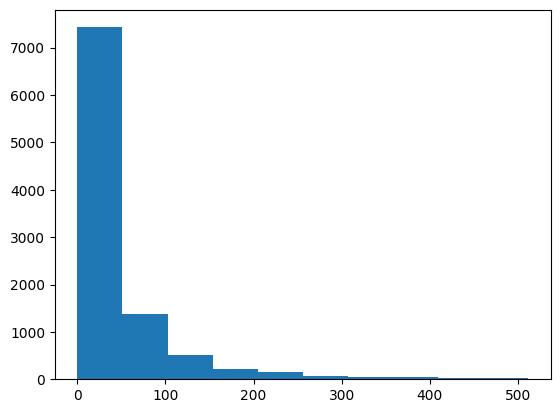

95% of bodies are below 187 tokens


In [6]:
plt.hist(body_lengths, range=(0, 512))
plt.show()
print("95% of bodies are below", int(np.quantile(np.array(body_lengths), 0.95)), "tokens")

As names are even shorter, we can almost harmlessly truncate context length at 256. Which is good, because context larget than 512 sometimes don't fit on T4 GPU.

To fine-tune causal model on seq2seq task I will cast it as predicting the code as continuation of description, the parts will be separated with one of the special tokens of this model (`<filename>`, even somewhat close semantically to the current task).

In [7]:
sep = "<filename>"
sep_id = tokenizer(sep)["input_ids"][0]
print(sep, sep_id)
@typed
def tokenize_function(example: Mapping[str, str | int], pad=True) -> Mapping[str, list[int]]:
    result = tokenizer(
        example["body"][:800] + sep + example["name"],
        truncation=True,
        max_length=256,
        padding="max_length",
    )
    result["labels"] = result["input_ids"]
    return result

subset_size = 30000
subset = dataset["train"].select(range(subset_size))
tokenized = subset.map(tokenize_function, batched=False).remove_columns(["body", "name"])

<filename> 5


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

# Visualization

Let's check what the model does before fine-tuning. First it's interesting to see what the model generates on its own, and second, how difficult each of the tokens from the ground truth labels is for it.


In [8]:
@typed
def show_string_with_weights(s: list[str], w: list[float] | Float[TT, "seq"]) -> None:
    from IPython.display import HTML, display
    from matplotlib.colors import rgb2hex
    from matplotlib import colormaps

    cmap = colormaps["coolwarm"]
    def brighten(rgb):
        return tuple([(x + 1) / 2 for x in rgb])
    colors = [brighten(cmap(alpha)) for alpha in w]
    html_str_colormap = " ".join(
        [
            f'<span style="background-color: {rgb2hex(color)}; padding: 1px; margin: 0px; border-radius: 5px;">{word}</span>'
            for word, color in zip(s, colors)
        ]
    )
    display(HTML(html_str_colormap))

@typed
def sample_and_logprobs(sample: Mapping[str, list[int]]) -> None:
    model.cuda()
    with t.no_grad():
        inputs = {k: t.tensor([v], device="cuda") for k, v in sample.items()}
        ids = inputs["input_ids"][0]
        pos = next(i for i in range(len(ids)) if ids[i] == sep_id)
        pad = next((i for i in range(pos, len(ids)) if ids[i] == tokenizer.pad_token_id), len(ids))
        truncated = {k: v[:, :pos+1] for k, v in inputs.items()}
        sampled_tokens = (
            model.generate(
                **truncated,
                max_new_tokens=6,
                pad_token_id=tokenizer.pad_token_id,
                bad_words_ids=[[tokenizer.pad_token_id], [tokenizer.eos_token_id]],
                do_sample=True,
            )[0]
            .detach()
            .cpu()
        )
        without_prompt = tokenizer.decode(sampled_tokens[pos+1:])

        output = model(**inputs)
        loss = output.loss.cpu().detach()
        logprobs: Float[TT, "seq vocab"] = F.log_softmax(
            output.logits.cpu().detach(), dim=-1
        ).squeeze(0)

        labels: Int[TT, "seq 1"] = inputs["input_ids"][0, 1:].cpu().unsqueeze(-1)
        lp_per_token: Float[TT, "seq"] = logprobs[:-1].gather(-1, labels).squeeze(-1)[pos+1:pad]
        weights = F.tanh(-lp_per_token)  # 0 for perfect prediction, 1 for infinite loss
        tokens = [tokenizer.decode(i) for i in inputs["input_ids"][0, pos+1:pad]]

        show_string_with_weights(tokens, weights)
        print(without_prompt)


So initially the model is completely wrong on most of the tokens and even series of them, though it still guesses some tokens, maybe by in-context learning.

In [9]:
for sample in tokenized.select(range(32)):
    sample_and_logprobs(sample)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


public/java/src/


src/main/java/


<caret>ttribute attribute


platform/platform-impl/


src/io/github/


src/test/java/


com/intellij/icons/



import java.util.*;


com/intellij/execution/


com/intellij/codeInsight


code_problems/leetcode/


trueml-core/src


import/import/import.


<|endoftext|>


<|endoftext|>


//src/main/java


<|endoftext|>


 }<|endoftext|>


src/main/java/


org.gradle.api/


src/main/java/


buildSrc/src/main


com.facebook.buck.


java/core/src/


Generated/index.html<gh_stars>


com.facebook.buck.


com/intellij/ide/


com/intellij/compiler/


$macroName$.java



src/uk/ac/


$PROJECT_NAME$.sub


com.eoi.jax


# Training

Many parameters here are optimized for memory: `fp16`, `optim`, `per_device_train_batch_size`. For learning rate, I tried values up to `1e-4`, where it starts to diverge, and around `1e-5` it is still somewhat unstable, so I picked `5e-6`. Also tried gradient accumulation, but it makes iterations several times slower without visible benefit (maybe it becomes better in the end, though). I don't use validation, because there is only 1 epoch so all samples are new.

In [10]:
training_args = TrainingArguments(
    output_dir="trainer",
    fp16=True,
    per_device_train_batch_size=1,
    optim="adafactor",
    learning_rate=5e-6,
    logging_steps=10,
    num_train_epochs=1,
    save_total_limit=1,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
)

In [11]:
trainer.train()

Step,Training Loss
10,12.224200
20,11.812100
30,9.536200
40,8.789400
50,8.234100
60,7.233100
70,7.784000
80,5.616100
90,6.243500
100,4.796100


TrainOutput(global_step=30000, training_loss=0.28190049670934675, metrics={'train_runtime': 23541.0221, 'train_samples_per_second': 1.274, 'train_steps_per_second': 1.274, 'total_flos': 4.699085340672e+16, 'train_loss': 0.28190049670934675, 'epoch': 1.0})

Let's see what the model had learnt.

In [12]:
for sample in tokenized.select(range(32)):
    sample_and_logprobs(sample)

substituteRecursivelyOrCaseSensitive


substituteAndSaveSettingsXmlFile


substituteInContentAndAttributesOf


substituteRecursivelyOrKeepCase


substitute2ElementsOrDirectoriesInner


substituteInPlaceAllCaseSensitive


registerMacroExpanderPathInfo


addMappingEntryToPlainMap


replaceAllByReferenceInPlaceOld


replaceTextByMacroExpands


escapeMacroContentIfNeededWithoutRegex


getSlashCountAtHeadAnd


findNextNonMacroInText


hashCodeUtilV2AddMethod


shouldCreateFileElementForInner


canDeleteElementInPluginContext


checkAttrsCompletionForSingleElement


loadPropertiesFileDependenciesSettingsFrom


makeEndRunnableForSingleTest


loadEncodingConfigurationFromProjectConfiguration


loadExtensionPointConfigurationImpl1


loadExtensionGlobalOptionsForModule


loadComponentsByExtensionsToOption


loadComponentsInternallyInternally


loadExtensionWithDefaultSettingsImpl<filename>


loadComponentExtensionImplImpl3


loadExtensionSettingsFromTagInner


loadExtensionPropertiesImplV7


addFileHierarchyReplacementsFromFile


registerMacroExpansionForTestsImpl


addPathReplacementMapItemFor


substituteMacrosAndExpandVarsIn


As we see, the model is now much less surprised by the method names, and its generations also started to look like method names, sometimes even close to ground truth ones. 

# Some hacks to clear GPU memory

In [13]:
1/0

ZeroDivisionError: ignored

In [ ]:
import gc
gc.collect()
t.cuda.empty_cache()